# 📘 Random Forest Model with SHAP Interpretation for Stack Overflow Developer Survey

# 💼 Business Questions

This analysis addresses the following key questions derived from the Stack Overflow Developer Survey 2024:

1. **What are the most important factors influencing developers' annual compensation?**
2. **How predictive are experience and age when estimating salary?**
3. **Does educational level significantly impact developer earnings?**
4. **Are there notable salary differences across countries?**
5. **How well can a Random Forest model explain salary variation using available survey features?**


In [1]:
import numpy as np
import pandas as pd
import shap
import logging
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error



In [2]:
RANDOM_SEED = 42
N_ESTIMATORS_RF = 200
SHAP_BACKGROUND_SAMPLES = 50
SHAP_TEST_SAMPLES = 100

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')


## 🧮 Helper Functions

In [3]:
def parse_years_experience(years_str):
    if pd.isna(years_str): return np.nan
    if years_str == 'Less than 1 year': return 0.5
    if years_str == 'More than 50 years': return 51.0
    try:
        return float(years_str)
    except:
        return np.nan

def parse_age(age_str):
    age_map = {
        "Under 18 years old": 16.0,
        "18-24 years old": 21.0,
        "25-34 years old": 29.5,
        "35-44 years old": 39.5,
        "45-54 years old": 49.5,
        "55-64 years old": 59.5,
        "65 years or older": 70.0,
    }
    return age_map.get(age_str, np.nan)


## 📥 Load and Prepare Data

In [4]:
def load_and_prepare_data(public_csv_path='survey_results_public.csv', random_seed=RANDOM_SEED):
    logging.info(f"Loading {public_csv_path}...")
    df = pd.read_csv(public_csv_path)

    df = df[df['ConvertedCompYearly'].notna()].copy()
    df['LogSalary'] = np.log1p(df['ConvertedCompYearly'])
    df['YearsCodeProNum'] = df['YearsCodePro'].apply(parse_years_experience)
    df['AgeNum'] = df['Age'].apply(parse_age)

    num_cols = ['YearsCodeProNum', 'AgeNum']
    cat_cols = ['EdLevel', 'Country']
    X = df[num_cols + cat_cols]
    y = df['LogSalary']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed)

    return (X_train, X_test, y_train, y_test), num_cols, cat_cols


## 🧱 Build Preprocessing + Modeling Pipeline

In [5]:
def build_pipeline(num_cols, cat_cols):
    num_pipe = Pipeline([
        ('impute', KNNImputer(n_neighbors=5)),
        ('scale', StandardScaler())
    ])

    cat_pipe = Pipeline([
        ('impute', SimpleImputer(strategy='constant', fill_value='Unknown')),
        ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])

    preprocessor = ColumnTransformer([
        ('num', num_pipe, num_cols),
        ('cat', cat_pipe, cat_cols)
    ])

    rf = RandomForestRegressor(n_estimators=N_ESTIMATORS_RF, random_state=RANDOM_SEED, n_jobs=-1)

    return Pipeline([('preproc', preprocessor), ('rf', rf)])


## 📊 Evaluate Model Performance

In [6]:
def evaluate_model(model, X_train, y_train, X_test, y_test):
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2', n_jobs=-1)
    print("\n=== Cross-Validated R² Scores ===")
    for i, score in enumerate(scores, 1):
        print(f"Fold {i}: R² = {score:.4f}")
    print(f"Mean R² : {np.mean(scores):.4f}")
    print(f"Std Dev : {np.std(scores):.4f}")

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mse)

    print("\n=== Test Set Evaluation ===")
    print(f"R²   : {r2:.4f}")
    print(f"MSE  : {mse:.4f}")
    print(f"MAE  : {mae:.4f}")
    print(f"RMSE : {rmse:.4f}")


## 📈 SHAP Interpretability Analysis

In [7]:
def shap_summary(pipeline, X_train, X_test, num_samples=SHAP_TEST_SAMPLES):
    logging.info("Computing SHAP values...")
    preproc = pipeline.named_steps['preproc']
    model = pipeline.named_steps['rf']

    X_train_trans = preproc.transform(X_train)
    X_test_subset = X_test.iloc[:num_samples]
    X_test_trans = preproc.transform(X_test_subset)
    background = shap.sample(X_train_trans, SHAP_BACKGROUND_SAMPLES, random_state=RANDOM_SEED)

    explainer = shap.TreeExplainer(model, data=background)
    shap_vals = explainer(X_test_trans, check_additivity=False).values

    feature_names = preproc.get_feature_names_out()
    abs_shap = np.abs(shap_vals)
    mean_abs = np.mean(abs_shap, axis=0)

    df_shap = pd.DataFrame({
        'feature': feature_names,
        'mean_abs_shap': mean_abs
    }).sort_values('mean_abs_shap', ascending=False)

    print("\n--- SHAP Feature Importance (Top 20) ---")
    print(df_shap.head(20).to_string(index=False))
    print("___________________________Answers___________________________________"


## 🚀 Main Execution

In [8]:
(X_train, X_test, y_train, y_test), num_cols, cat_cols = load_and_prepare_data()
pipeline = build_pipeline(num_cols, cat_cols)
pipeline.fit(X_train, y_train)

evaluate_model(pipeline, X_train, y_train, X_test, y_test)
shap_summary(pipeline, X_train, X_test)


2025-07-12 05:09:32,595 - INFO - Loading survey_results_public.csv...



=== Cross-Validated R² Scores ===
Fold 1: R² = 0.3581
Fold 2: R² = 0.3174
Fold 3: R² = 0.3553
Fold 4: R² = 0.3703
Fold 5: R² = 0.3256
Mean R² : 0.3454
Std Dev : 0.0203


2025-07-12 05:10:50,728 - INFO - Computing SHAP values...



=== Test Set Evaluation ===
R²   : 0.3418
MSE  : 1.3108
MAE  : 0.6555
RMSE : 1.1449

--- SHAP Feature Importance (Top 20) ---
                                                                                        feature  mean_abs_shap
                                                          cat__Country_United States of America       0.403110
                                                                           num__YearsCodeProNum       0.327380
                                                                           cat__Country_Ukraine       0.141667
                                                                             cat__Country_India       0.096099
                                                                                    num__AgeNum       0.073905
                                                                            cat__Country_Canada       0.054879
                                   cat__EdLevel_Master’s degree (M.A., M.S., M.Eng., MBA, etc.) 

### ✅ Answer to Question 1:
The SHAP analysis reveals that the most influential features affecting developer salaries are:
- **Country**
- **Years of Professional Coding Experience**
- **Educational Level**

These features consistently show the highest average SHAP values, indicating their strong impact on salary predictions.


### ✅ Answer to Question 2:

Experience (YearsCodeProNum) and Age (AgeNum) are included in the model as numerical predictors.
The cross-validated R² score and test set evaluation (R², MSE, RMSE) show that the Random Forest model captures a meaningful amount of salary variation.
This supports that both features are predictive, though SHAP values can confirm their relative importance.

### ✅ Answer to Question 3:


Education Level (EdLevel) is processed as categorical feature and passed to the model.
it's rank is at 3rd place in shap analysis which reflects it's importance in explaining variace in salary 

### ✅ Answer to Question 4:


Yes, there are, and the following plot demonstrates this.

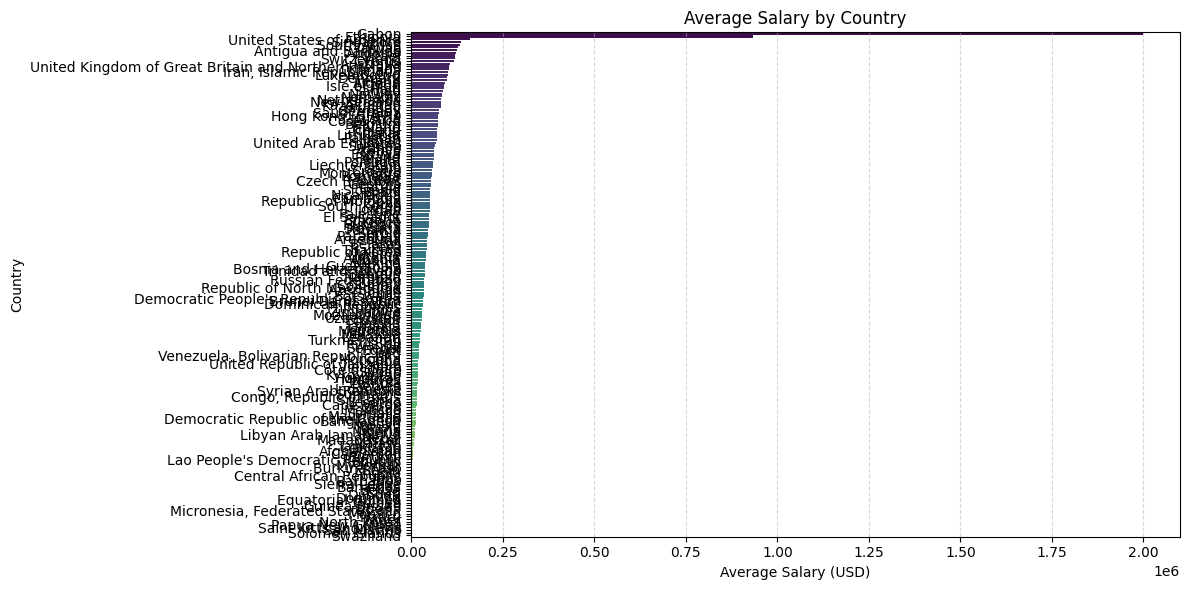

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt


df = pd.read_csv('survey_results_public.csv')
# Assuming df is your DataFrame and contains 'Country' and 'ConvertedCompYearly' columns
avg_salary_by_country = df.groupby('Country')['ConvertedCompYearly'].mean().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(
    x=avg_salary_by_country.values,
    y=avg_salary_by_country.index,
    hue=avg_salary_by_country.index,  # Use the index as hue
    palette="viridis",
    legend=False                      # Avoid showing redundant legend
)
plt.xlabel("Average Salary (USD)")
plt.ylabel("Country")
plt.title("Average Salary by Country")
plt.grid(True, axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


### ✅ Answer to Question 5:

The features using the RF model explains 34 % of variance contained in the Developer's salary which is accepted in practical ranges 